Epoch [10/300], Loss: 33.3921
Epoch [20/300], Loss: 24.3482
Epoch [30/300], Loss: 22.3909
Epoch [40/300], Loss: 20.5251
Epoch [50/300], Loss: 18.0945
Epoch [60/300], Loss: 16.4540
Epoch [70/300], Loss: 14.3845
Epoch [80/300], Loss: 13.9510
Epoch [90/300], Loss: 11.3082
Epoch [100/300], Loss: 11.0737
Epoch [110/300], Loss: 9.0574
Epoch [120/300], Loss: 8.4441
Epoch [130/300], Loss: 9.2291
Epoch [140/300], Loss: 7.2381
Epoch [150/300], Loss: 6.4055
Epoch [160/300], Loss: 6.2801
Epoch [170/300], Loss: 5.5362
Epoch [180/300], Loss: 5.6998
Epoch [190/300], Loss: 5.7381
Epoch [200/300], Loss: 4.9467
Epoch [210/300], Loss: 6.5494
Epoch [220/300], Loss: 4.9865
Epoch [230/300], Loss: 4.7124
Epoch [240/300], Loss: 4.2411
Epoch [250/300], Loss: 4.2184
Epoch [260/300], Loss: 4.6375
Epoch [270/300], Loss: 4.3323
Epoch [280/300], Loss: 4.9664
Epoch [290/300], Loss: 3.9796
Epoch [300/300], Loss: 3.4347
Test Loss: 8.1358
Root Mean Squared Error (RMSE): 2.8523
Correlation coefficient: 0.8453


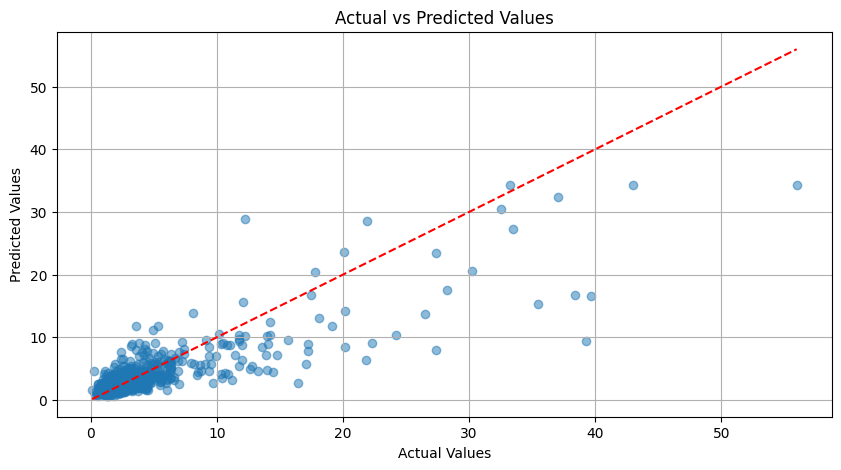

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Load your cleaned data
data = pd.read_csv('data.csv')
data = data.drop(columns=['Unnamed: 0'])

# Define target variable
target = 'oc_iso.10694_w.pct'

# Extract features and target
X = data.drop(columns=[target]).values
y = data[target].values

# Apply Savitzky-Golay smoothing filter
def apply_savitzky_golay(X, window_length=11, polyorder=2, deriv=0, delta=2):
    smoothed_X = savgol_filter(X, window_length=window_length, polyorder=polyorder, deriv=deriv, delta=delta, axis=0)
    return smoothed_X

# Apply Standard Normal Variate (SNV) transformation
def standard_normal_variate(X):
    snv_X = (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)
    return snv_X

# Apply Savitzky-Golay filter
#X_sg = apply_savitzky_golay(X, window_length=11, polyorder=2, deriv=0, delta=2)

# Apply SNV transformation
#X_snv = standard_normal_variate(X_sg)

# Normalize features
scaler = StandardScaler()
X_snv_scaled = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_snv_scaled, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward pass through LSTM layer
        out, _ = self.lstm(x, (h0, c0))
        # Select the last time step
        out = out[:, -1, :]
        # Forward pass through fully connected layer
        out = self.fc(out)
        return out

# Hyperparameters
input_size = X_train.shape[1]  # Number of features
hidden_size = 256
output_size = 1  # For regression
num_layers = 5
num_epochs = 300
learning_rate = 0.001

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_train.unsqueeze(1))  # Add sequence dimension
    loss = criterion(outputs.squeeze(), y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    # Make predictions on the test set
    predictions = model(X_test.unsqueeze(1)).squeeze()
    
    # Calculate test loss
    test_loss = criterion(predictions, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')
    
    # Convert predictions and y_test to numpy arrays
    y_pred_np = predictions.numpy()
    y_test_np = y_test.numpy()

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred_np))
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    
    # Calculate correlation coefficient
    correlation, _ = pearsonr(y_test_np, y_pred_np)
    print(f'Correlation coefficient: {correlation:.4f}')
    
    # Plot actual vs. predicted values
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test_np, y_pred_np, alpha=0.5)
    plt.plot([min(y_test_np), max(y_test_np)], [min(y_test_np), max(y_test_np)], color='red', linestyle='--')  # Perfect prediction line
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.grid(True)
    plt.show()


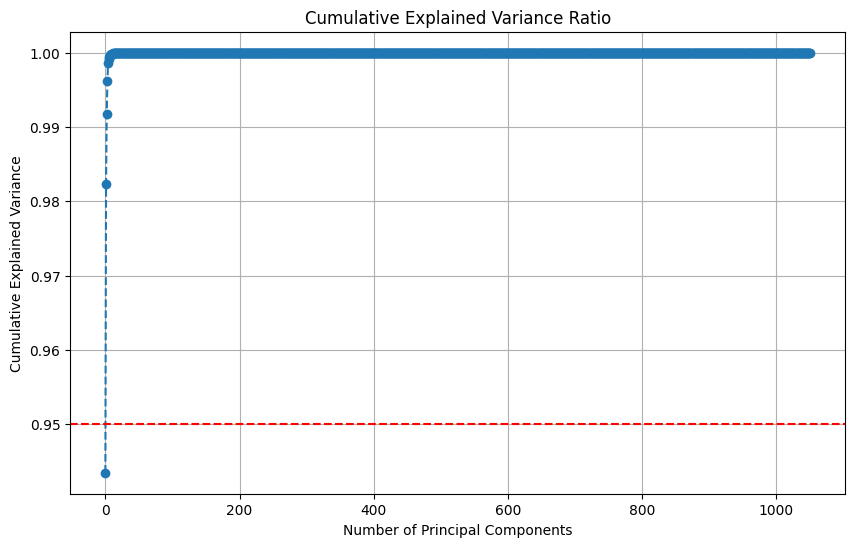

Number of components to explain 95% of the variance: 2
Epoch [10/300], Loss: 35.2475
Epoch [20/300], Loss: 21.7746
Epoch [30/300], Loss: 21.4748
Epoch [40/300], Loss: 20.7801
Epoch [50/300], Loss: 19.9446
Epoch [60/300], Loss: 18.7406
Epoch [70/300], Loss: 17.4580
Epoch [80/300], Loss: 16.4464
Epoch [90/300], Loss: 15.7158
Epoch [100/300], Loss: 15.1964
Epoch [110/300], Loss: 14.7633
Epoch [120/300], Loss: 14.4026
Epoch [130/300], Loss: 14.0672
Epoch [140/300], Loss: 13.7919
Epoch [150/300], Loss: 13.6167
Epoch [160/300], Loss: 13.3583
Epoch [170/300], Loss: 13.2365
Epoch [180/300], Loss: 13.1053
Epoch [190/300], Loss: 13.0026
Epoch [200/300], Loss: 12.9736
Epoch [210/300], Loss: 12.9672
Epoch [220/300], Loss: 12.9004
Epoch [230/300], Loss: 12.8693
Epoch [240/300], Loss: 12.7844
Epoch [250/300], Loss: 12.7585
Epoch [260/300], Loss: 12.7364
Epoch [270/300], Loss: 12.6326
Epoch [280/300], Loss: 12.7273
Epoch [290/300], Loss: 12.7103
Epoch [300/300], Loss: 12.5948
Test Loss: 15.7240
Root 

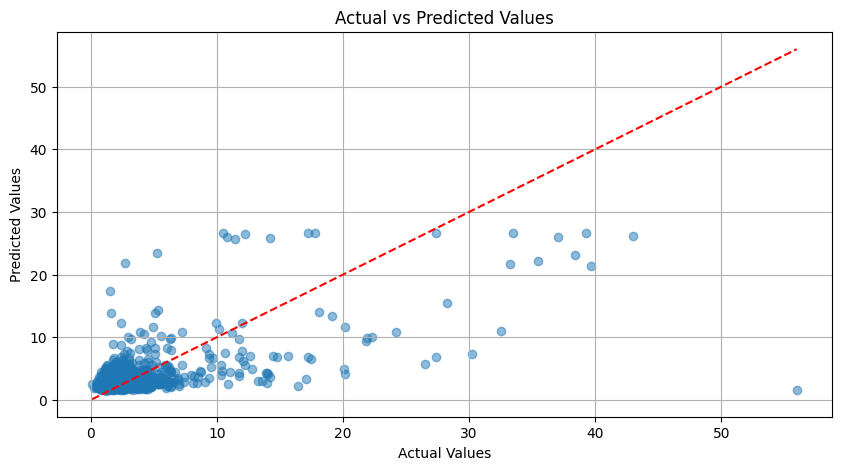

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Load your cleaned data
data = pd.read_csv('data.csv')
data = data.drop(columns=['Unnamed: 0'])

# Define target variable
target = 'oc_iso.10694_w.pct'

# Extract features and target
X = data.drop(columns=[target]).values
y = data[target].values

# Apply Savitzky-Golay smoothing filter
def apply_savitzky_golay(X, window_length=11, polyorder=2, deriv=0, delta=2):
    smoothed_X = savgol_filter(X, window_length=window_length, polyorder=polyorder, deriv=deriv, delta=delta, axis=0)
    return smoothed_X

# Apply Standard Normal Variate (SNV) transformation
def standard_normal_variate(X):
    snv_X = (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)
    return snv_X

# Apply Savitzky-Golay filter
# X_sg = apply_savitzky_golay(X, window_length=11, polyorder=2, deriv=0, delta=2)

# Apply SNV transformation
# X_snv = standard_normal_variate(X_sg)

# Normalize features
scaler = StandardScaler()
X_snv_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_snv_scaled)

# Plot explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Determine number of components to explain 95% variance
num_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f'Number of components to explain 95% of the variance: {num_components_95}')

# Transform features using the selected number of principal components
pca = PCA(n_components=num_components_95)
X_pca_reduced = pca.fit_transform(X_snv_scaled)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca_reduced, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward pass through LSTM layer
        out, _ = self.lstm(x, (h0, c0))
        # Select the last time step
        out = out[:, -1, :]
        # Forward pass through fully connected layer
        out = self.fc(out)
        return out

# Hyperparameters
input_size = X_train.shape[1]  # Number of features after PCA
hidden_size = 256
output_size = 1  # For regression
num_layers = 5
num_epochs = 300
learning_rate = 0.001

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_train.unsqueeze(1))  # Add sequence dimension
    loss = criterion(outputs.squeeze(), y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    # Make predictions on the test set
    predictions = model(X_test.unsqueeze(1)).squeeze()
    
    # Calculate test loss
    test_loss = criterion(predictions, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')
    
    # Convert predictions and y_test to numpy arrays
    y_pred_np = predictions.numpy()
    y_test_np = y_test.numpy()

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred_np))
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    
    # Calculate correlation coefficient
    correlation, _ = pearsonr(y_test_np, y_pred_np)
    print(f'Correlation coefficient: {correlation:.4f}')
    
    # Plot actual vs. predicted values
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test_np, y_pred_np, alpha=0.5)
    plt.plot([min(y_test_np), max(y_test_np)], [min(y_test_np), max(y_test_np)], color='red', linestyle='--')  # Perfect prediction line
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.grid(True)
    plt.show()


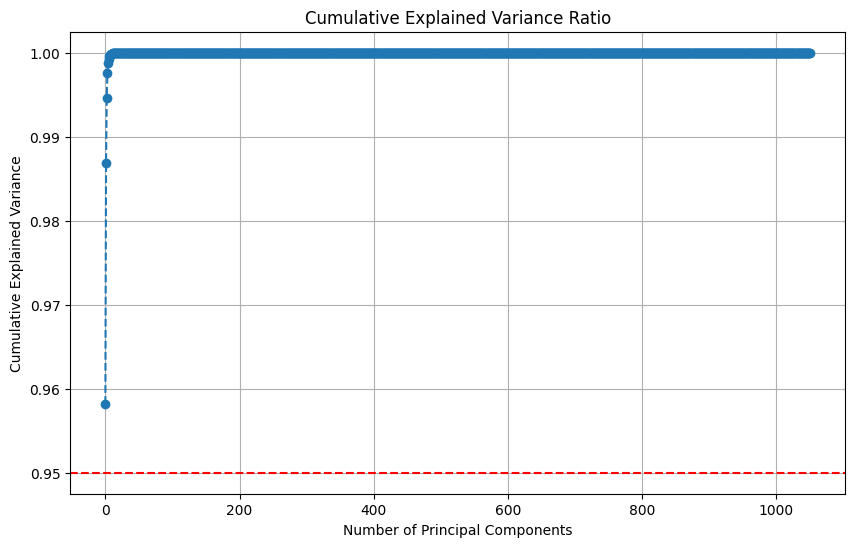

Number of components to explain 95% of the variance: 23
Epoch [10/500], Loss: 35.2702
Epoch [20/500], Loss: 23.8671
Epoch [30/500], Loss: 18.5789
Epoch [40/500], Loss: 15.4976
Epoch [50/500], Loss: 13.0274
Epoch [60/500], Loss: 11.1166
Epoch [70/500], Loss: 9.6889
Epoch [80/500], Loss: 8.5271
Epoch [90/500], Loss: 7.6092
Epoch [100/500], Loss: 6.8814
Epoch [110/500], Loss: 6.2746
Epoch [120/500], Loss: 5.7318
Epoch [130/500], Loss: 5.2407
Epoch [140/500], Loss: 4.8009
Epoch [150/500], Loss: 4.3786
Epoch [160/500], Loss: 3.9899
Epoch [170/500], Loss: 3.6296
Epoch [180/500], Loss: 3.2956
Epoch [190/500], Loss: 2.9826
Epoch [200/500], Loss: 2.6916
Epoch [210/500], Loss: 2.4503
Epoch [220/500], Loss: 2.2861
Epoch [230/500], Loss: 2.0846
Epoch [240/500], Loss: 1.9353
Epoch [250/500], Loss: 1.7989
Epoch [260/500], Loss: 1.7105
Epoch [270/500], Loss: 1.6159
Epoch [280/500], Loss: 1.5132
Epoch [290/500], Loss: 1.4540
Epoch [300/500], Loss: 1.3888
Epoch [310/500], Loss: 1.3325
Epoch [320/500], 

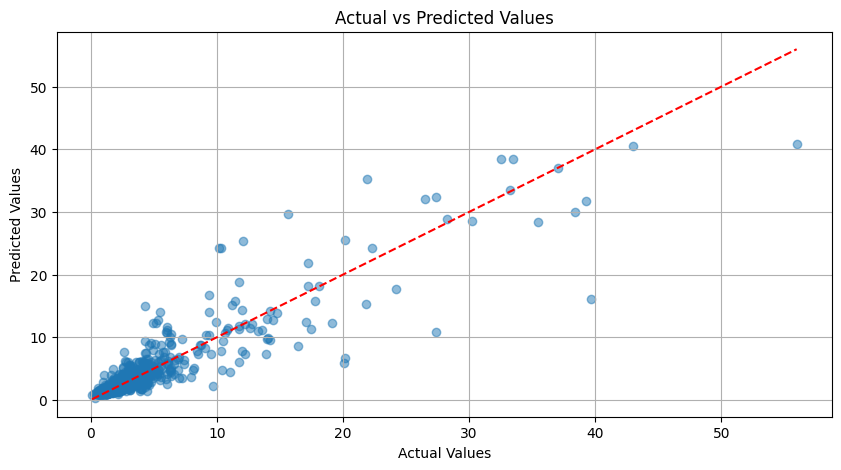

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Load your cleaned data
data = pd.read_csv('data.csv')
data = data.drop(columns=['Unnamed: 0'])

# Define target variable
target = 'oc_iso.10694_w.pct'

# Extract features and target
X = data.drop(columns=[target]).values
y = data[target].values

# Apply Savitzky-Golay smoothing filter
def apply_savitzky_golay(X, window_length=11, polyorder=2, deriv=0, delta=2):
    smoothed_X = savgol_filter(X, window_length=window_length, polyorder=polyorder, deriv=deriv, delta=delta, axis=0)
    return smoothed_X

# Apply Standard Normal Variate (SNV) transformation
def standard_normal_variate(X):
    snv_X = (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)
    return snv_X

# Apply Savitzky-Golay filter
# X_sg = apply_savitzky_golay(X, window_length=11, polyorder=2, deriv=0, delta=2)

# Apply SNV transformation
# X_snv = standard_normal_variate(X_sg)

# Apply PCA before scaling
pca = PCA()
X_pca = pca.fit_transform(X)

# Plot explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Determine number of components to explain 95% variance
num_components_95 = np.argmax(cumulative_variance >= 0.99999) + 1
print(f'Number of components to explain 95% of the variance: {num_components_95}')

# Transform features using the selected number of principal components
pca = PCA(n_components=num_components_95)
X_pca_reduced = pca.fit_transform(X)

# Normalize features
scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca_reduced)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca_scaled, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward pass through LSTM layer
        out, _ = self.lstm(x, (h0, c0))
        # Select the last time step
        out = out[:, -1, :]
        # Forward pass through fully connected layer
        out = self.fc(out)
        return out

# Hyperparameters
input_size = X_train.shape[1]  # Number of features after PCA and scaling
hidden_size = 256
output_size = 1  # For regression
num_layers = 5
num_epochs = 500
learning_rate = 0.001

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_train.unsqueeze(1))  # Add sequence dimension
    loss = criterion(outputs.squeeze(), y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    # Make predictions on the test set
    predictions = model(X_test.unsqueeze(1)).squeeze()
    
    # Calculate test loss
    test_loss = criterion(predictions, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')
    
    # Convert predictions and y_test to numpy arrays
    y_pred_np = predictions.numpy()
    y_test_np = y_test.numpy()

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred_np))
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    
    # Calculate correlation coefficient
    correlation, _ = pearsonr(y_test_np, y_pred_np)
    print(f'Correlation coefficient: {correlation:.4f}')
    
    # Plot actual vs. predicted values
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test_np, y_pred_np, alpha=0.5)
    plt.plot([min(y_test_np), max(y_test_np)], [min(y_test_np), max(y_test_np)], color='red', linestyle='--')  # Perfect prediction line
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.grid(True)
    plt.show()


Epoch [10/300], Loss: 34.0975, Test Loss: 35.6379
Epoch [20/300], Loss: 25.0347, Test Loss: 27.2827
Epoch [30/300], Loss: 23.6880, Test Loss: 26.0720
Epoch [40/300], Loss: 22.9277, Test Loss: 25.2047
Epoch [50/300], Loss: 22.1752, Test Loss: 24.7277
Epoch [60/300], Loss: 21.4416, Test Loss: 24.3914
Epoch [70/300], Loss: 20.9027, Test Loss: 24.1241
Epoch [80/300], Loss: 20.2814, Test Loss: 23.7914
Epoch [90/300], Loss: 19.7427, Test Loss: 23.3910
Epoch [100/300], Loss: 18.6828, Test Loss: 22.9435
Epoch [110/300], Loss: 17.7178, Test Loss: 22.4151
Early stopping on epoch 120
Final Test Loss: 23.0624
Final RMSE: 4.8023
Final Correlation coefficient: 0.3661


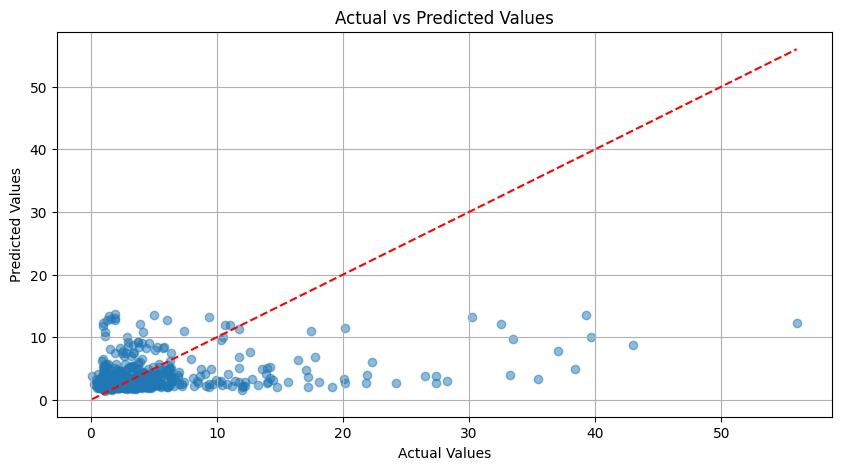

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Load your cleaned data
data = pd.read_csv('data.csv')
data = data.drop(columns=['Unnamed: 0'])

# Define target variable
target = 'oc_iso.10694_w.pct'

# Extract features and target
X = data.drop(columns=[target]).values
y = data[target].values

# Apply Savitzky-Golay smoothing filter
def apply_savitzky_golay(X, window_length=11, polyorder=2, deriv=0, delta=2):
    smoothed_X = savgol_filter(X, window_length=window_length, polyorder=polyorder, deriv=deriv, delta=delta, axis=0)
    return smoothed_X

# Apply Standard Normal Variate (SNV) transformation
def standard_normal_variate(X):
    snv_X = (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)
    return snv_X

# Apply Savitzky-Golay filter
X_sg = apply_savitzky_golay(X, window_length=11, polyorder=2, deriv=0, delta=2)

# Apply SNV transformation
X_snv = standard_normal_variate(X_sg)

# Normalize features
scaler = StandardScaler()
X_snv_scaled = scaler.fit_transform(X_snv)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_snv_scaled, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define LSTM model with dropout
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_prob=0.3):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers with dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# Hyperparameters
input_size = X_train.shape[1]  # Number of features
#hidden_size = 128  # Reduced from 256
#output_size = 1  # For regression
##num_layers = 3  # Reduced from 5
#num_epochs = 300
#learning_rate = 0.0001  # Reduced from 0.001
#dropout_prob = 0.3  # Dropout probability for regularization


hidden_size = 256
output_size = 1  # For regression
num_layers = 5
num_epochs = 300
learning_rate = 0.001
dropout_prob = 0.3

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, output_size, num_layers, dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Early stopping variables
best_loss = float('inf')
patience, trigger_times = 10, 0

# Training loop
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_train.unsqueeze(1))  # Add sequence dimension
    loss = criterion(outputs.squeeze(), y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Evaluate on test set for early stopping
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test.unsqueeze(1)).squeeze()
        test_loss = criterion(test_predictions, y_test)
    
    if test_loss < best_loss:
        best_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        
    if trigger_times >= patience:
        print(f"Early stopping on epoch {epoch+1}")
        break
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

# Final evaluation
model.eval()
with torch.no_grad():
    predictions = model(X_test.unsqueeze(1)).squeeze()
    test_loss = criterion(predictions, y_test)
    print(f'Final Test Loss: {test_loss.item():.4f}')
    
    y_pred_np = predictions.numpy()
    y_test_np = y_test.numpy()

    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred_np))
    print(f'Final RMSE: {rmse:.4f}')
    
    correlation, _ = pearsonr(y_test_np, y_pred_np)
    print(f'Final Correlation coefficient: {correlation:.4f}')
    
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test_np, y_pred_np, alpha=0.5)
    plt.plot([min(y_test_np), max(y_test_np)], [min(y_test_np), max(y_test_np)], color='red', linestyle='--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.grid(True)
    plt.show()
